In [1]:
from models.base_network import BaseNetwork, BaseNetwork1, EmbedLayer, FlattenLayer
from file_handling.load_datasets import load_mnist
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.utils
import torchvision.models.resnet as resnet_utils

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

from preprocessing.noise_models import gaussian_noise, shot_noise, defocus_blur, zoom_blur, brightness, snow, clipped_zoom
import seaborn as sns
sns.set()

### Loading Datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 255*x)])
test_data = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
train_data = datasets.CIFAR10(root='./cifar-10', train=True, download=False, transform=transform)

In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=2)

### Initializing Networks

In [4]:
class MiniResNet(resnet_utils.ResNet):

    def __init__(self, block, layers, num_classes=10):
        super(resnet_utils.ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [5]:
cross_criterion = nn.CrossEntropyLoss()
square_criterion = nn.modules.loss.MSELoss()

In [6]:
mini_resnet = BaseNetwork1(MiniResNet(resnet_utils.BasicBlock, [1,1]))

In [7]:
mini_resnet_opt = optim.RMSprop(mini_resnet.parameters(), lr=0.0005)

In [8]:
mini_resnet

BaseNetwork1(
  (0): MiniResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [9]:
# mini_resnet.train_model(epochs=1, print_every=2000, optimizer=mini_resnet_opt, 
#                         train_loader=train_loader, test_loader=test_loader, criterion=cross_criterion)

In [69]:
mini_resnet.load_model("saved_models/mini_reg_resnet.pt")

In [14]:
print(mini_resnet.test_model_once(noise_function=None, severity=0, test_loader=test_loader))
print(mini_resnet.test_model_once(noise_function=None, severity=0, test_loader=train_loader))

74.07
78.21


In [15]:
mini_resnet.save_model("saved_models/mini_reg_resnet.pt")

In [10]:
trunc_mini_resnet = MiniResNet(resnet_utils.BasicBlock, [1,1])

In [11]:
trunc_mini_resnet(train_data[0][0][None,:,:,:])

tensor([[-0.0555,  0.1149,  0.2044,  0.3063, -0.5139, -0.5468, -0.4665,  0.0790,
         -1.0172,  1.4611]], grad_fn=<AddmmBackward>)

In [12]:
trunc_mini_resnet = nn.Sequential(*list(trunc_mini_resnet.children())[:-1])
trunc_mini_resnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (con

In [92]:
mini_emb_resnet = BaseNetwork1(trunc_mini_resnet, FlattenLayer(), nn.Sigmoid(), 
                               EmbedLayer(64, 8000, sigma=.0005), 
                               nn.BatchNorm1d(8000, track_running_stats=False, affine=False),
                               nn.Linear(8000, 10))
mini_emb_resnet

BaseNetwork1(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [93]:
mini_emb_resnet_opt = optim.RMSprop(mini_emb_resnet.parameters(), lr=0.0005)

In [94]:
mini_emb_resnet.train_model(epochs=1, print_every=train_loader.batch_size, optimizer=mini_emb_resnet_opt, 
                        train_loader=train_loader, test_loader=test_loader, criterion=cross_criterion)

epoch: 1, iteration: 15, train acc: 0.36, loss: 1.612643
epoch: 1, iteration: 31, train acc: 0.41, loss: 1.654459
epoch: 1, iteration: 47, train acc: 0.42, loss: 1.531231
epoch: 1, iteration: 63, train acc: 0.44, loss: 1.347849
epoch: 1, iteration: 79, train acc: 0.48, loss: 1.415921
epoch: 1, iteration: 95, train acc: 0.42, loss: 2.250523
epoch: 1, iteration: 111, train acc: 0.54, loss: 1.676418
epoch: 1, iteration: 127, train acc: 0.49, loss: 1.729936
epoch: 1, iteration: 143, train acc: 0.50, loss: 1.441882
epoch: 1, iteration: 159, train acc: 0.44, loss: 1.283083
epoch: 1, iteration: 175, train acc: 0.46, loss: 1.190379
epoch: 1, iteration: 191, train acc: 0.50, loss: 1.521252
epoch: 1, iteration: 207, train acc: 0.50, loss: 1.436052
epoch: 1, iteration: 223, train acc: 0.50, loss: 1.408921
epoch: 1, iteration: 239, train acc: 0.51, loss: 1.174248
epoch: 1, iteration: 255, train acc: 0.48, loss: 1.617293
epoch: 1, iteration: 271, train acc: 0.46, loss: 1.626677
epoch: 1, iteration:

epoch: 1, iteration: 2271, train acc: 0.52, loss: 1.792946
epoch: 1, iteration: 2287, train acc: 0.56, loss: 0.789516
epoch: 1, iteration: 2303, train acc: 0.56, loss: 1.396913
epoch: 1, iteration: 2319, train acc: 0.47, loss: 1.533346
epoch: 1, iteration: 2335, train acc: 0.49, loss: 1.490829
epoch: 1, iteration: 2351, train acc: 0.54, loss: 1.134183
epoch: 1, iteration: 2367, train acc: 0.55, loss: 1.434938
epoch: 1, iteration: 2383, train acc: 0.47, loss: 1.192589
epoch: 1, iteration: 2399, train acc: 0.53, loss: 1.975932
epoch: 1, iteration: 2415, train acc: 0.56, loss: 1.671133
epoch: 1, iteration: 2431, train acc: 0.56, loss: 1.595320
epoch: 1, iteration: 2447, train acc: 0.50, loss: 1.281645
epoch: 1, iteration: 2463, train acc: 0.54, loss: 1.185938
epoch: 1, iteration: 2479, train acc: 0.51, loss: 1.628448
epoch: 1, iteration: 2495, train acc: 0.50, loss: 1.099401
epoch: 1, iteration: 2511, train acc: 0.55, loss: 1.271186
epoch: 1, iteration: 2527, train acc: 0.52, loss: 1.3019

([0.1,
  0.36328125,
  0.41015625,
  0.41796875,
  0.44140625,
  0.48046875,
  0.421875,
  0.53515625,
  0.48828125,
  0.49609375,
  0.44140625,
  0.4609375,
  0.5,
  0.49609375,
  0.50390625,
  0.51171875,
  0.48046875,
  0.46484375,
  0.52734375,
  0.52734375,
  0.48046875,
  0.50390625,
  0.49609375,
  0.51171875,
  0.49609375,
  0.5078125,
  0.46484375,
  0.48828125,
  0.53125,
  0.515625,
  0.5078125,
  0.51171875,
  0.47265625,
  0.5234375,
  0.48828125,
  0.49609375,
  0.49609375,
  0.5,
  0.53515625,
  0.5078125,
  0.46875,
  0.5,
  0.54296875,
  0.5234375,
  0.4921875,
  0.54296875,
  0.4921875,
  0.4765625,
  0.51953125,
  0.50390625,
  0.5,
  0.484375,
  0.52734375,
  0.53515625,
  0.48046875,
  0.515625,
  0.49609375,
  0.55078125,
  0.50390625,
  0.515625,
  0.546875,
  0.53515625,
  0.50390625,
  0.52734375,
  0.5390625,
  0.546875,
  0.50390625,
  0.5390625,
  0.51953125,
  0.484375,
  0.53515625,
  0.5234375,
  0.57421875,
  0.5234375,
  0.50390625,
  0.49609375,
  0.52

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (5): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (con

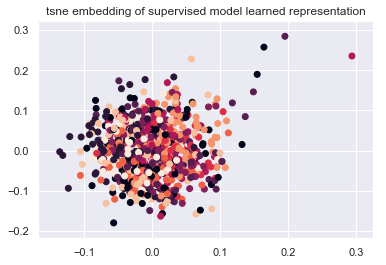

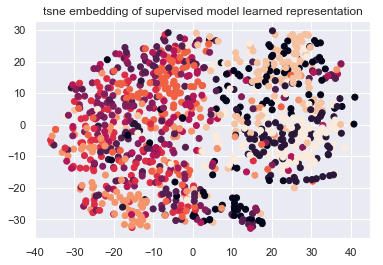

In [95]:
images, labels = iter(test_loader).next()
from plotting import visualization
print(list(mini_emb_resnet.children())[0])
visualization.visualize_activations(images, labels, list(mini_emb_resnet.children())[4], mini_emb_resnet)
visualization.tsne(images, labels, list(mini_emb_resnet.children())[4], mini_emb_resnet)

AdaptiveAvgPool2d(output_size=(1, 1))
(1000, 64)


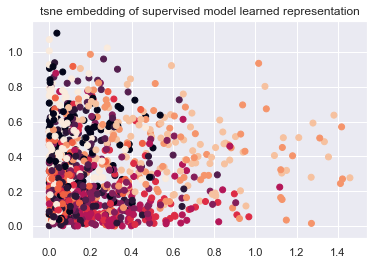

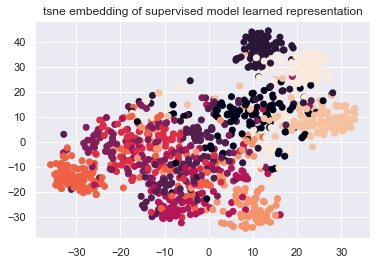

In [70]:
class SaveFeatures():
	features=None
	def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
	def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
	def remove(self): self.hook.remove()

from sklearn.manifold import TSNE
def tsne(images, labels, representation_layer, model, name=None):
	activations = SaveFeatures(representation_layer)
	outputs = model(images)
	activations.remove()
	activations = np.squeeze(activations.features)
	tsne_embedded = TSNE(n_components=2).fit_transform(activations)
	plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], c=labels)
	plt.title("tsne embedding of supervised model learned representation")
	if name:
		plt.savefig(f"output/tsne/{name}")
	else:
		plt.show()

def visualize_activations(images, labels, layer, model, name=None):
	activations = SaveFeatures(layer)
	outputs = model(images)
	activations.remove()
	activations = np.squeeze(activations.features)
	print(activations.shape)
	plt.scatter(activations[:, 0], activations[:, 1], c=labels)
	plt.title("tsne embedding of supervised model learned representation")
	if name:
		plt.savefig(f"output/activations/{name}")
	else:
		plt.show()

visualize_activations(images, labels, list(list(mini_resnet.children())[0].children())[-2], mini_resnet)
tsne(images, labels, list(list(mini_resnet.children())[0].children())[-2], mini_resnet)

In [96]:
def visualize_filters(layer, name=None):
	layer1 = layer.weight.data
	supervised_filters = [f - np.min(f.numpy()) for f in layer1]
	supervised_filters = np.array([f.numpy() / np.max(f.numpy()) for f in supervised_filters])[:, :3, :, :]
	grid = torchvision.utils.make_grid(torch.Tensor(supervised_filters)).numpy()
	plt.imshow(np.transpose(grid, (1, 2, 0)))
	plt.axis("off")
	if name == None:
		plt.show()
	else:
		plt.savefig(f"output/filters/{name}")

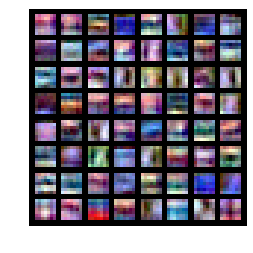

In [98]:
visualize_filters(list(list(mini_emb_resnet.children())[0].children())[0])

In [ ]:
reg_net = BaseNetwork1(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        FlattenLayer(),
                        nn.Linear(256, 5000), nn.ReLU(),
                        nn.Linear(5000, 100), nn.ReLU(),
                        nn.Linear(100, 10))
# reg_net = BaseNetwork("reg_net", [(3, 16, 3),(16,32,3), (32, 64, 3),(256,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "conv", "fc", "fc", "fc"])
# emb_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5), (800,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "fc", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5),(800,100),(100,10)],
#                                 ["conv", "conv", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["fc", "fc", "fc"])
reg_net_opt = optim.RMSprop(reg_net.parameters(), lr=0.0005)

In [ ]:
reg_net

In [ ]:
emb_net = BaseNetwork1(nn.Conv2d(3, 16, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(16, 32, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2,2),
                        FlattenLayer(),
                        EmbedLayer(256, 5000),
                        nn.Linear(5000, 100), nn.ReLU(),
                        nn.Linear(100, 10))
# emb_net = BaseNetwork("emb_net", [(3, 16, 3),(16,32,3), (32, 64, 3),(256,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "conv", "emb", "fc","fc"])
# emb_net = BaseNetwork("emb_net", [(3, 16, 5),(16,32,5), (800,5000),(5000,100),(100,10)],
#                                 ["conv", "conv", "emb", "fc", "fc"])
# emb_net = BaseNetwork("emb_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["emb", "fc", "fc"])
emb_net_opt = optim.RMSprop(emb_net.parameters(), lr=0.000005, momentum=0.9)

In [ ]:
emb_net

### Training, Saving and Loading Models

In [ ]:
good_model.train_model(train_loader, 5, good_model_opt, criterion)

In [ ]:
reg_net.train_model(train_loader, 3, reg_net_opt, criterion)
reg_net.save_model("saved_models/reg_net_test.pt")

In [ ]:
emb_net.train_model(train_loader, 5, emb_net_opt, criterion)
emb_net.save_model("saved_models/emb_net_test.pt")

In [ ]:
reg_net.load_model("saved_models/reg_net_test.pt")
emb_net.load_model("saved_models/emb_net_test.pt")

### Testing Pure Accuracy on Test Set

In [ ]:
print("Test accuracy of REGULAR network with NO NOISE: {}".format(reg_net.test_model_once(test_loader, None, 0)))
print("Test accuracy of EMBEDDED network with NO NOISE: {}".format(emb_net.test_model_once(test_loader, None, 0)))

### Testing on Gaussian Noise

In [ ]:
print("Test accuracy of REGULAR network on GAUSSIAN NOISE: {}".format(reg_net.test_model(test_loader, gaussian_noise)))
print("Test accuracy of EMBEDDED network on GAUSSIAN NOISE: {}".format(emb_net.test_model(test_loader, gaussian_noise)))

In [ ]:
true = [57.19, 52.68, 45.93, 43.5, 40.63]
cool = [57.99, 56.6, 53.89, 52.77, 50.17]

plt.plot(np.r_[1:6], true)
plt.plot(np.r_[1:6], cool)
plt.legend(["Regular", "Embedding"])
plt.title("Model Accuracy on Gaussian Noise")
plt.xlabel("Noise Severity")
plt.xticks(range(1,6))
plt.ylabel("Accuracy")
plt.show()

### Testing on Shot Noise

In [ ]:
print("Test accuracy of REGULAR network on SHOT NOISE: {}".format(reg_net.test_model(test_loader, shot_noise)))
print("Test accuracy of EMBEDDED network on SHOT NOISE: {}".format(emb_net.test_model(test_loader, shot_noise)))

In [ ]:
true = [59.44, 57.59, 51.77, 47.88, 42.49]
cool = [58.48, 57.81, 55.65, 54.02, 51.42]

plt.plot(np.r_[1:6], true)
plt.plot(np.r_[1:6], cool)
plt.legend(["Regular", "Embedding"])
plt.title("Model Accuracy on Shot Noise")
plt.xlabel("Noise Severity")
plt.xticks(range(1,6))
plt.ylabel("Accuracy")
plt.show()

### Testing on Zoom Blur

In [ ]:
print("Test accuracy of REGULAR network on ZOOM BLUR: {}".format(reg_net.test_model(test_loader, zoom_blur)))
print("Test accuracy of EMBEDDED network on ZOOM BLUR: {}".format(emb_net.test_model(test_loader, zoom_blur)))

### Inspecting Convolution Weights

In [ ]:
weights_reg, bias_reg = deepcopy(reg_net.state_dict()['0.weight']), deepcopy(reg_net.state_dict()['0.bias'])
weights_emb, bias_emb = deepcopy(emb_net.state_dict()['0.weight']), deepcopy(emb_net.state_dict()['0.bias'])

In [ ]:
def norm(im):
    im = deepcopy(im)
    im = im - torch.min(im)
    im = im / torch.max(im)
    return im
plt.imshow(train_data[0][0].int().permute(1, 2 ,0))
plt.show()

In [ ]:
def imshow(img, to_norm=True, figsize=(15, 10)):
    img = deepcopy(img)
    if to_norm:
        img = norm(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
test_im,_ = train_data[0]
test_im = test_im[None,:,:,:]
test_im_reg = F.conv2d(test_im, weight=weights_reg, bias=bias_reg).permute(1,0,2,3)

for i in range(len(weights_reg)):
    weights_reg[i] = norm(weights_reg[i])
    test_im_reg[i] = norm(test_im_reg[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_reg), to_norm=False)
imshow(torchvision.utils.make_grid(weights_reg), to_norm=False)




In [ ]:
test_im_emb = F.conv2d(test_im, weight=weights_emb, bias=bias_emb).permute(1,0,2,3)

# print(test_im_reg)

for i in range(len(weights_emb)):
    weights_emb[i] = norm(weights_emb[i])
    test_im_emb[i] = norm(test_im_emb[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_emb), to_norm=False)
imshow(torchvision.utils.make_grid(weights_emb), to_norm=False)

In [ ]:
resnet_model = resnet18(pretrained=True)
resnet_model

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
trunc_resnet = nn.Sequential(*list(resnet_model.children())[:-3])

# trunc_resnet

In [ ]:
added_module = BaseNetwork1(FlattenLayer(), EmbedLayer(1024, 5000), nn.ReLU(), 
                             nn.Linear(5000, 10))

our_resnet = BaseNetwork1(trunc_resnet, added_module)

our_opt = optim.RMSprop(our_resnet.parameters(), lr=.0005)

In [ ]:
baseline = BaseNetwork1(trunc_resnet, FlattenLayer(), nn.ReLU(), nn.Linear(1024, 10))
base_opt = optim.Adagrad(baseline.parameters(), lr=.005)

In [ ]:
# baseline

In [ ]:
baseline.train_model(epochs=5, opt=base_opt, criterion=criterion, train_loader=train_loader)

In [ ]:
baseline.test_model_once(noise_function=None, severity=0, test_loader=test_loader)

In [ ]:
our_resnet.train_model(epochs=5, opt=our_opt, criterion=criterion, train_loader=train_loader)

In [ ]:
for epoch in range(5):
    run_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        base_opt.zero_grad()
        outputs = baseline(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        base_opt.step()
        run_loss += loss.item()
        if i % train_loader.batch_size == train_loader.batch_size - 1:
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, run_loss / (train_loader.batch_size)))
            run_loss = 0.0